# Master Kernel
##### Tiempo estimado de corrida: XX
___
### Análisis Exploratorio

##### Integrantes:
+ Alvarado, Rubén
+ Penovi, Francisco

In [2]:
############################ROOT#############################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

STATUS_CSV = '../DataSet/status.csv'
STATION_CSV = '../DataSet/station.csv'
TRIP_CSV = '../DataSet/trip.csv'
WEATHER_CSV = '../DataSet/weather.csv'

dfStation = pd.read_csv(STATION_CSV, parse_dates=['installation_date'], infer_datetime_format=True)
# dfStatus = pd.read_csv(STATUS_CSV)   OJO CON ESTE QUE ES MUY PESADO
dfTrip = pd.read_csv(TRIP_CSV, parse_dates=['start_date', 'end_date'], infer_datetime_format=True)
dfWeather = pd.read_csv(WEATHER_CSV, parse_dates=['date'], infer_datetime_format=True)

''' Recibe un plot de barras y les asigna sus valores
    encima de cada una de ellas. Se puede setear textsize y alpha.'''
def autolabel(ax, textsize, alpha):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in ax.patches:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height),
                ha='center', va='bottom', size=textsize, alpha=alpha)


''' Utilizada como parámetro para función DataFrame.apply
    Para cada row, devuelve el zip code correspondiente a la ciudad.'''
def cityNameToZipCode(row) :

    if row.city == 'San Francisco' :
        return '94107'

    if row.city == 'Redwood City' :
        return '94063'

    if row.city == 'Palo Alto' :
        return '94301'

    if row.city == 'Mountain View' :
        return '94041'

    if row.city == 'San Jose' :
        return '95113'

    raise ValueError('Malo malo!')


''' Utilizada para generar un DataFrame nuevo que contiene las filas de la ciudad
    pasada por parámetro únicamente.'''
def makeNewDataFrameWithCity(df, city) :

    dic = {'date':[], 'city':[], 'zip_code':[], 'duration':[], 'max_temp_f':[], 'min_temp_f':[]}

    for i in range(0, len(df)):
        if (df.iloc[i]['city'] == city ) :
            dic['date'].append(df.iloc[i]['date'])
            dic['city'].append(df.iloc[i]['city'])
            dic['zip_code'].append(df.iloc[i]['zip_code'])
            dic['duration'].append(df.iloc[i]['duration'])
            dic['max_temp_f'].append(df.iloc[i]['max_temperature_f'])
            dic['min_temp_f'].append(df.iloc[i]['min_temperature_f'])

    return pd.DataFrame.from_dict(data=dic, orient='columns')


''' Utilizada para clasificar en grupos a las horas del día.'''
def getMomentOfDay(row):

    if row.hour < 5:
        return 'Small Hours'
    if  5 <= row.hour < 12:
        return 'Morning'
    if 12 <= row.hour < 14:
        return 'Noon'
    if 14 <= row.hour < 18:
        return 'Afternoon'
    if 18 <= row.hour < 21:
        return 'Evening'
    if 21 <= row.hour <= 23:
        return 'Night'

###############################ENDROOT#############################

### ----- INICIO NOTEBOOK 01 -----

### Subscription Type VS Trip Duration

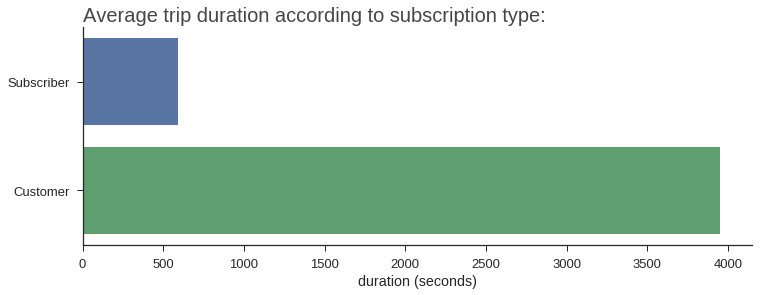

In [4]:
result = dfTrip[['duration', 'start_date', 'end_date', 'subscription_type']]\
        .sort_values(by=['start_date', 'end_date'])\
        .groupby(by=['subscription_type'])\
        .agg('mean').reset_index()
        
plt.figure(figsize=(12,4))

sns.set(font_scale=1.30)
sns.set_style('ticks')

bars = sns.barplot(x='duration',\
                   y='subscription_type',\
                   order=['Subscriber', 'Customer'],\
                   data=result)

sns.despine()

bars.set(xlabel='duration (seconds)',\
         ylabel='');

bars.set_title('Average trip duration according to subscription type:', size=20, loc='left', alpha=0.85);
plt.show()

### Observo la varianza de las duraciones
Para realizar recortes de volúmenes de datos muy pequeños pero con valores muy altos o muy bajos que alteran la naturaleza de los datos.

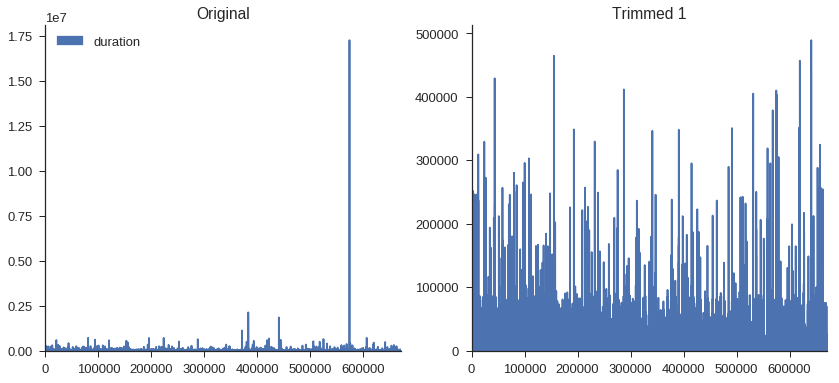

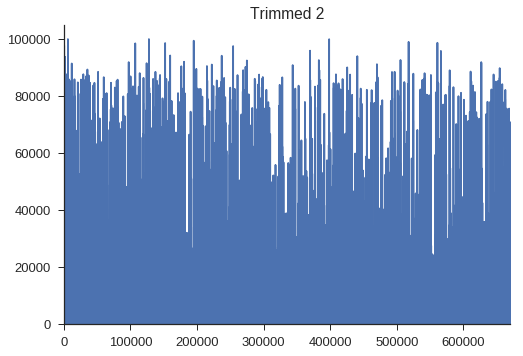

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(14, 6)

sns.despine()

dfTrip['duration'].plot(ax=axes[0], kind='area', legend=True);
axes[0].set_title('Original');
dfTrip[(60*2 <= dfTrip.duration) & (dfTrip.duration <= 500000)][['duration']].plot(ax=axes[1], kind='area', legend=False);
axes[1].set_title('Trimmed 1');
dfTrip[(60*2 <= dfTrip.duration) & (dfTrip.duration <= 100000)][['duration']].plot(kind='area', legend=False).set_title('Trimmed 2');

sns.despine()

plt.show();

**Para facilitar la comprensión de la dispersión de los datos (ya que en los gráficos no se puede apreciar)  
voy a armar un nuevo DataFrame con la cantidad de viajes dentro de los intervalos existentes.**

In [6]:
# Armo intervalos de duracion y me fijo cual es el intervalo más común
durationIntervals = {}
maxDuration = dfTrip.duration.max()
minDuration = dfTrip.duration.min()

while ( maxDuration >= 120) :    
    interval = (maxDuration/2 + 1, maxDuration)
    durationIntervals[interval] = 0
    maxDuration /= 2

durationIntervals[(minDuration, maxDuration)] = 0

# Cuento la cantidad de trips en cada intervalo y relleno el diccionario:
for interval in durationIntervals.keys() :
    durationIntervals[interval] = dfTrip[(interval[0] <= dfTrip.duration) & (dfTrip.duration <= interval[1])]\
                                        .duration.count()

In [7]:
dfIntervals = pd.DataFrame.from_dict(durationIntervals, orient='index').reset_index()
dfIntervals.columns = ['interval', 'trips']
dfIntervals.sort_values(by=['interval'], inplace=True)
dfIntervals

,interval,trips
10,"(60, 65)",305
15,"(66, 131)",7274
4,"(132, 263)",82834
18,"(264, 527)",254285
5,"(528, 1054)",246085
0,"(1055, 2108)",48838
14,"(2109, 4216)",11213
1,"(4217, 8432)",8361
8,"(8433, 16865)",6203
13,"(16866, 33731)",3117


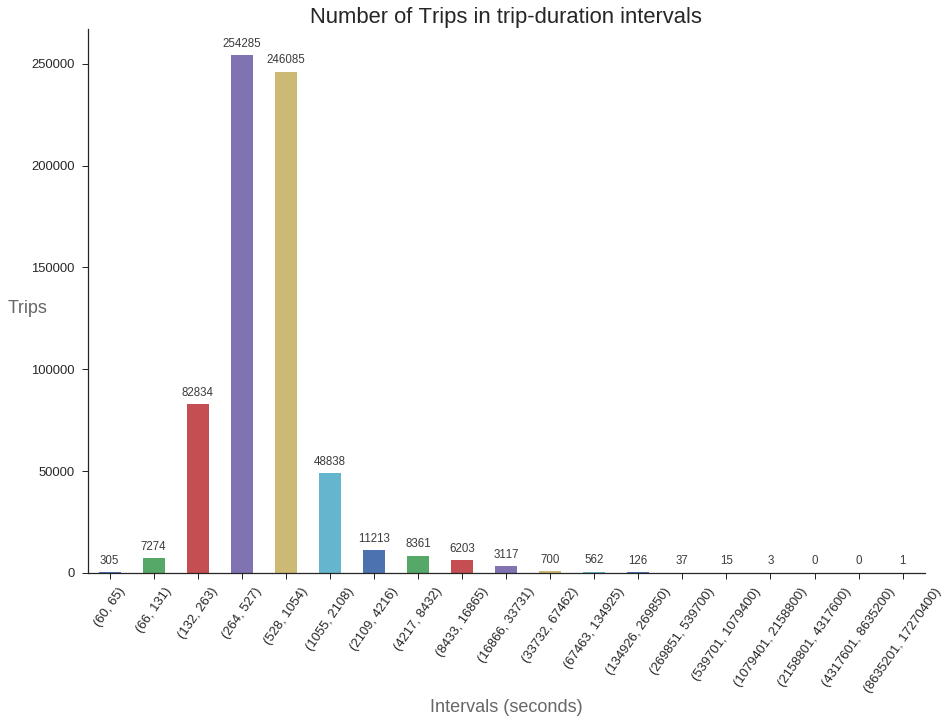

In [8]:
ax = dfIntervals.plot(kind='bar', x='interval', y='trips', color=sns.color_palette(), legend=False)
ax.figure.set_size_inches(15, 10)

sns.despine()
ax.set_title('Number of Trips in trip-duration intervals', size=22)
ax.set_xlabel('Intervals (seconds)', size=18, alpha=0.7)
ax.set_ylabel('Trips', size=18, rotation='horizontal', position=(0, 0.47), alpha=0.7)
plt.xticks(rotation=55, size=13)

autolabel(ax, 11.5, 0.9)      # Definida en root.py

plt.show()

### Recorto viajes menores a 2 minutos y mayores a 6 horas
Podemos observar en el gráfico de arriba que las duraciones más comunes de los viajes estan entre el rango de **4** a **17** minutos.  
Existen viajes extremadamente largos (200 días por ejemplo) que alteran los promedios de los viajes al igual que viajes extremadamente cortos que no representan casos habituales en el set de datos y perjudican a la comprensión y generalización de los mismos.

**De hecho en la página oficial el uso extendido de las bicicletas es desalentado para este servicio:**
> *"If you plan on using a bicycle for an extended period of time,
> we encourage you to rent a bike at a local bike shop or 
> rental business."*

In [10]:
lendfTrip = len(dfTrip)

###################################################################
# Filtro dfTrip por viajes de duracion entre 2 y 6 horas

dfTrip = dfTrip[(2*60 <= dfTrip.duration) & (dfTrip.duration <= 6*3600)]

###################################################################

print "\nAntes del recorte:", lendfTrip, "\nDespués del recorte:", len(dfTrip), "\n"
print "Datos perdidos:", '%' + str(100 - (len(dfTrip) / float(lendfTrip))*100.0)


Antes del recorte: 669959 
Después del recorte: 661556 

Datos perdidos: %1.25425585745


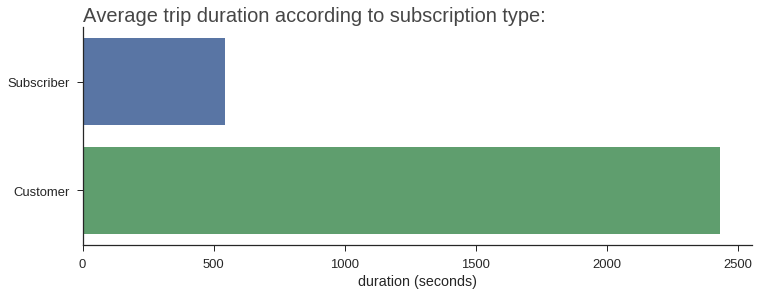

In [11]:
result = dfTrip[['duration', 'start_date', 'end_date', 'subscription_type']]\
        .sort_values(by=['start_date', 'end_date'])\
        .groupby(by=['subscription_type'])\
        .agg('mean').reset_index()
        
plt.figure(figsize=(12,4))

sns.set(font_scale=1.30)
sns.set_style('ticks')

bars = sns.barplot(x='duration',\
                   y='subscription_type',\
                   order=['Subscriber', 'Customer'],\
                   data=result)

sns.despine()

bars.set(xlabel='duration (seconds)',\
         ylabel='');

bars.set_title('Average trip duration according to subscription type:', size=20, loc='left', alpha=0.85);
plt.show()

Se puede apreciar que los valores de los **suscriptos** se mantienen iguales mientras que las duraciones de los viajes de los **clientes** rondan los 45 minutos, en oposición al gráfico anterior en donde éstos últimos sobrepasaban la hora.

Esto cobra un sentido más trascendente cuando se lo observa a la par con los precios listados en la página oficial:  
[SF Bay Area Bike Share](https://www.bayareabikeshare.com/pricing "Bay Area Bike Pricing") en donde se puede observar que a partir de los 30+ minutos de viaje, comienzan a haber pequeños recargos y luego de los 60+ minutos de viaje los recargos aumentan. Por lo que tiene sentido que en promedio los viajes no se excedan de los 60 minutos.

### ----- FIN NOTEBOOK 01 -----